# Cryosuction

* The increase of ice content in frozen zone can increase matrix suction, attracting soil water from the unfrozen zone into the freezing front.
* Unfrozen water content ~ $\mathbf{f}$ (temperature, suction)
* $\mathbf{f}$ ⇒ soil-freezing characteristic curve (SFCC)
* SFCC
  - Empirical expression:
    + $\mathrm{sat}_\mathrm{liquid}$ ~ $\mathbf{f}$ (temperature)
    + no cryosuction included (McKenzie et al., 2007) 
  - Physically (Clapeyron equation) based expression:
    + $\mathrm{sat}_\mathrm{liquid}$ ~ $\mathbf{f}$ (temperature, suction)
    + describe cryosuction (Painter et al., 2016)
    + analogous to soil-water retention curve (SWCC)

# Lab experiment

Experiment: Mizoguchi, 1990  
<img src='image/expsoil.png' width='200' height='280' alt='experimental soil column' align='left' />  

| Parameter (Stuurop et al., 2021 (demo1 folder))                    |          |                 
| :----------------------------------------------------------------- | :------: |  
| Permeability ($\mathrm{m}^2$)                                      | 3.19e-13 |
| Porosity                                                           | 0.535    |
| Van Genuchten $\alpha$ ($\mathrm{Pa}^{-1}$)                        | 1.11e-4  |
| Van Genuchten m                                                    | 0.32     |
| Residual water saturation                                          | 0.093    |
| Thermal conductivity, unfrozen ($\mathrm{Wm}^{-1}\mathrm{K}^{-1}$) | 0.67     |
| Thermal conductivity, dry ($\mathrm{Wm}^{-1}\mathrm{K}^{-1}$)      | 0.07     |
| Initial temperature ($^\circ$C)                                    | 6.7      |
| Initial water content                                              | 0.34     |
| Measured item                                                      | total water content |
| Measurement times (hours)                                          | 12, 24, 50 |

# Model setup

## General model configuration

Two .xml input files in this demo, one including cryosuction and the other not.
* cycle driver: 
  - Basic model configuration.
  <img src='image/expxml.png' width='400' height='200' alt='exp model configuration' align=center />
  - It sets up the simulation for freezing process inside soil.
  - Simulation time: 100 hours
* PKs:
  - Detailed setup for each part.
  - Permafrost flow (Richards-type three-phase two-components mass balance, Darcy)
  - Three-phase energy (Three-phase energy balance)
  - Mathematical equations see (Karra et al., 2014; Painter et al., 2016)

## Required for cryosuction setup

* pc_ice
* water retention evaluator
  - Change in matric suction due to freezing is considered through "**fpd permafrost model**" 
    also called the "freezing point depression model" (Painter et al., 2016)
  - Unfrozen water content is only temperature dependent, expressed by "**mck permafrost model**"
    (Mckenzie et al., 2007)

## Boundary and initial conditions

* permafrost flow
  - Neumann BC: $\mathrm{J}_\mathrm{w}$ = 0
  - IC water table = -2.4m (sets the initial water content close to that the experiment)
* three-phase energy
  - $\mathrm{T}_\mathrm{top}$ = -6°C
  - Bottom BC: $\mathrm{J}_\mathrm{e}$ = 0
  - IC temperature = 6.7°C

# Change to work directory and run model

# Observation vs. Modeling

In [24]:
%matplotlib inline
import sys, os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
def modeled(directory,t_sel,por):
    vis = ats_xdmf.VisFile(directory, time_unit='hr')
    vis.loadMesh(columnar=True)
    time = vis.times
    z = vis.centroids[:,-1]*100
    cv = vis.getArray('cell_volume')[0]
    wc,rho_l,T,theta_l,theta_i,theta_t = (np.zeros((len(t_sel),len(z))) for i in range(6))
    for i in range(len(t_sel)):
        wc[i] = vis.getArray('water_content')[t_sel[i]]
        rho_l[i] = vis.getArray('molar_density_liquid')[t_sel[i]]
        T[i] = vis.getArray('temperature')[t_sel[i]]-273.15
        theta_l[i] = vis.getArray('saturation_liquid')[t_sel[i]]*por
        theta_i[i] = vis.getArray('saturation_ice')[t_sel[i]]*por
        theta_t[i] = wc[i]/rho_l[i]/cv
        
    #for initial condition check only
#     wci = sum(vis.getArray('water_content')[0]/vis.getArray('molar_density_liquid')[0])/sum(cv)
#     print(wci)
    return theta_t,theta_i,T,z

## Mizoguchi (1990) experiment data: total water content

In [26]:
dataset_Mizoguchi1990=pd.read_csv('Mizoguchi(1990)_labexp_data.csv', header=[0,1])

wct_12 = dataset_Mizoguchi1990.iloc[:,0:2].values
wct_24 = dataset_Mizoguchi1990.iloc[:,3:5].values
wct_50 = dataset_Mizoguchi1990.iloc[:,6:8].values
wct_exp = [wct_12,wct_24,wct_50]

## Modeled data

Output includes:   
(1) total water content ($\mathrm{m}^3/\mathrm{m}^3$)  
(2) ice content ($\mathrm{m}^3/\mathrm{m}^3$)  
(3) temperature (°C)  
(4) vertical location (cm)

In [27]:
t_select = [12,24,50]        #selected time point in paper
por = 0.535

directory_cryo_ex = "cryos_labexpVSmodel/model_cryo_ic_8"
solution_cryo_ex = modeled(directory_cryo,t_select,por) 

directory_cryo = "cryos_labexpVSmodel/model_cryosuction"
solution_cryo = modeled(directory_cryo,t_select,por) 

directory_no = "cryos_labexpVSmodel/model_nocryosuction"
solution_no = modeled(directory_no,t_select,por)

# solution_cryo = [tot_cryo,ice_cryo,T_cryo,z_cryo]
# solution_no = [tot_no,ice_no,T_no,z_no]

## Experiment vs. model with/no cryosuction

In [28]:
# plot total water content, ice content, and temperature

def plot(solution,t,axs,color,label,fontsize=14):
    
    # solution=[tot,ice,T,z]
    solution_name = ['total water content','ice content','temperature']
    tid = t_select.index(t)
    for i in range(3):
        axs[i].plot(solution[i][tid][:],solution[-1][:],color=color,label=label)
        axs[i].set_yticks(range(0,22,2))
        axs[i].set_ylim(0,20)
        axs[i].set_ylabel('Elevation (cm)',fontsize=fontsize)
        axs[i].set_xlabel(solution_name[i],fontsize=fontsize)
        
    for i in range(2):
        axs[i].set_xticks(np.arange(0,0.6,0.1))
        axs[i].set_xlim(0,0.5)

    axs[2].set_xticks(np.arange(-6,7,2))
    axs[2].set_xlim(-6,6)

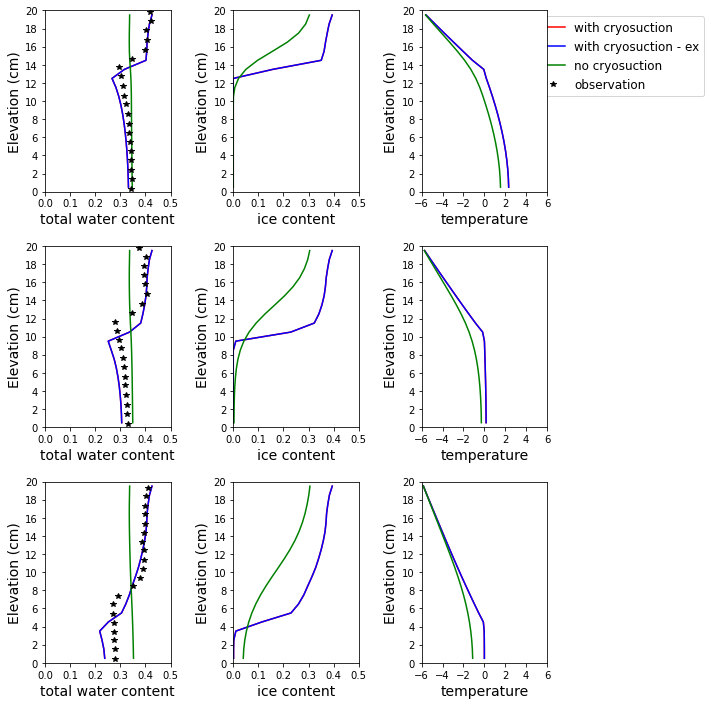

In [29]:
fig, axs = plt.subplots(len(t_select),3,figsize=(9,12))

for i in range(len(t_select)):
    plot(solution_cryo,t_select[i],axs[i],color='r',label='with cryosuction')
    plot(solution_cryo_ex,t_select[i],axs[i],color='b',label='with cryosuction - ex')
    plot(solution_no,t_select[i],axs[i],color='g',label='no cryosuction')
    ax = axs[i][0]
    xv = wct_exp[i][:,0]
    yv = wct_exp[i][:,1]
    ax.plot(xv, yv, 'k*',label='observation')

handles,labels = axs[0][0].get_legend_handles_labels()
axs[0][0].legend(handles,labels,fontsize=12,bbox_to_anchor=[5.3,1])    
plt.subplots_adjust(wspace=0.5, hspace=0.3)

# Change model setup for practice

* initial condition for flow:
  - hydrostatic head: -8
* boundary condition for energy:
  - constant temperature at bottom: 2°C